In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10


#Generates a tf.data.Dataset from image files.
data = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/Training_set",
    seed=100,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5122 files belonging to 10 classes.


In [3]:
class_names = data.class_names
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

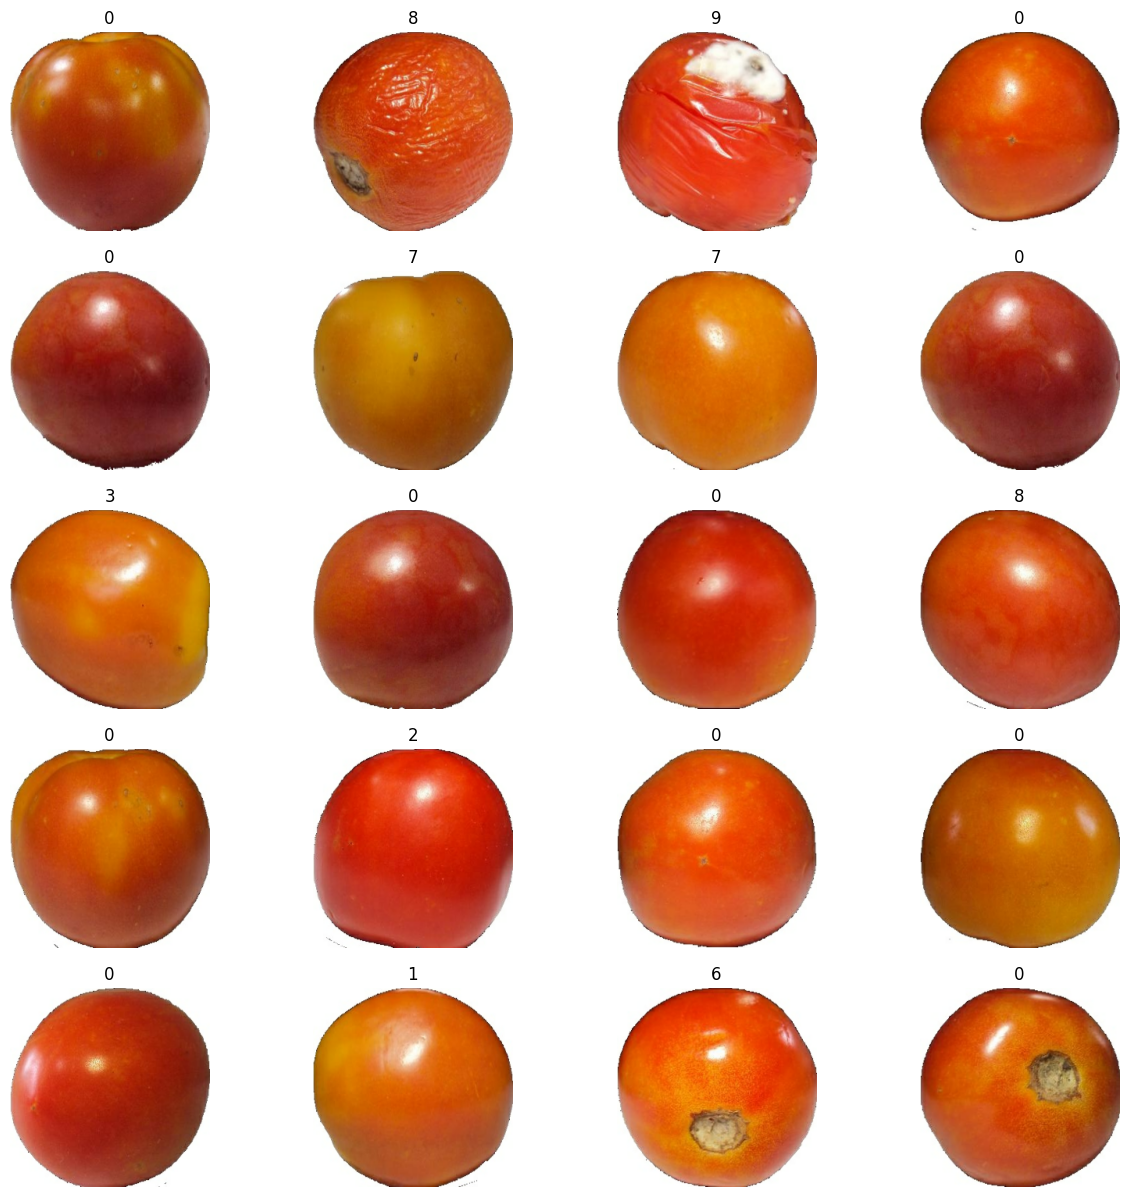

In [4]:
#plotting first few images
plt.figure(figsize=(15, 15))
for image, label in data.take(1):
    for i in range(20):
        ax = plt.subplot(5,4,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [5]:
def get_dataset_partitions_tf(input_data, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    '''
    This function splits the input data into train, validation and test data
    '''
    input_data_size = len(input_data)
    train_size = int(input_data_size * train_split)
    validation_size = int(input_data_size * val_split)
    
    if shuffle:
        input_data = input_data.shuffle(shuffle_size, seed=12)
        
    train_data = input_data.take(train_size)
    validation_data = input_data.skip(train_size).take(validation_size)
    test_data = input_data.skip(train_size).skip(validation_size)
    return train_data, validation_data, test_data

In [6]:
train_data, val_data, test_data = get_dataset_partitions_tf(data)
print('Train data size = ', len(train_data))
print('Test data size = ',len(test_data))
print('Validation data size = ',len(val_data))

Train data size =  128
Test data size =  17
Validation data size =  16


In [7]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
#images are resized to 256*256 
#images are scaled from 0 to 1

resize_and_rescale =  tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [9]:
#data augmentation to improve the accuracy of the model
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [10]:
'''
train_data = train_data.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)
'''


'\ntrain_data = train_data.map(\n    lambda x, y: (data_augmentation(x, training=True), y)\n).prefetch(buffer_size=tf.data.AUTOTUNE)\n'

In [11]:
#Model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation, 
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),   
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)



In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (32, 127, 127, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                      

In [13]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [14]:
history = model.fit(
    train_data,
    batch_size=BATCH_SIZE,
    validation_data=val_data,
    verbose=1,
    epochs=10,
)

Epoch 1/10
128/128 [==============================] - 461s 3s/step - loss: 2.0104 - accuracy: 0.4533 - val_loss: 1.7598 - val_accuracy: 0.4727
Epoch 2/10
128/128 [==============================] - 330s 3s/step - loss: 1.7415 - accuracy: 0.4641 - val_loss: 1.6389 - val_accuracy: 0.4727
Epoch 3/10
128/128 [==============================] - 1218s 10s/step - loss: 1.7025 - accuracy: 0.4641 - val_loss: 1.6352 - val_accuracy: 0.4824
Epoch 4/10
128/128 [==============================] - 306s 2s/step - loss: 1.6744 - accuracy: 0.4710 - val_loss: 1.6263 - val_accuracy: 0.4785
Epoch 5/10
128/128 [==============================] - 364s 3s/step - loss: 1.6487 - accuracy: 0.4769 - val_loss: 1.6053 - val_accuracy: 0.4844
Epoch 6/10
128/128 [==============================] - 325s 3s/step - loss: 1.6030 - accuracy: 0.4835 - val_loss: 1.5403 - val_accuracy: 0.4980
Epoch 7/10
128/128 [==============================] - 312s 2s/step - loss: 1.5761 - accuracy: 0.4867 - val_loss: 1.5313 - val_accuracy: 0.50

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [16]:
EPOCHS = 10

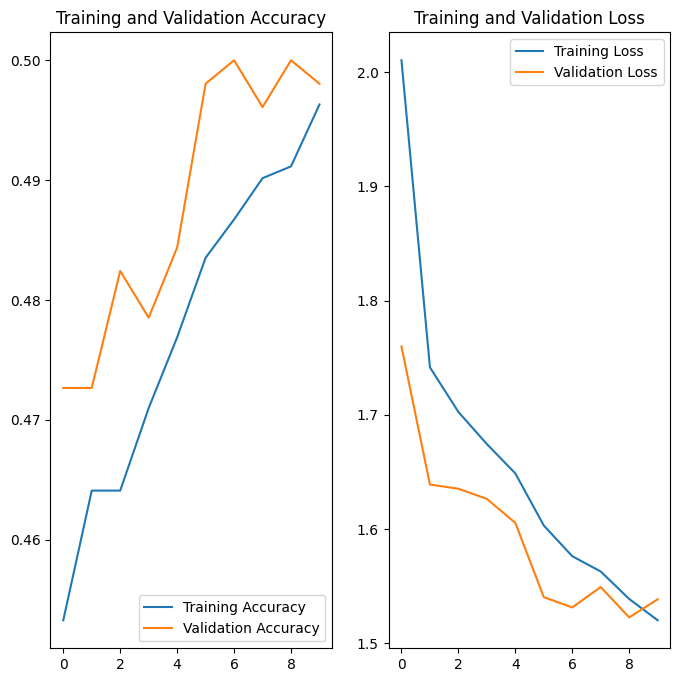

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
#plt.savefig('Accuracy.png')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss') 
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: 9
1/1 [==============================] - 1s 941ms/step
predicted label: 7


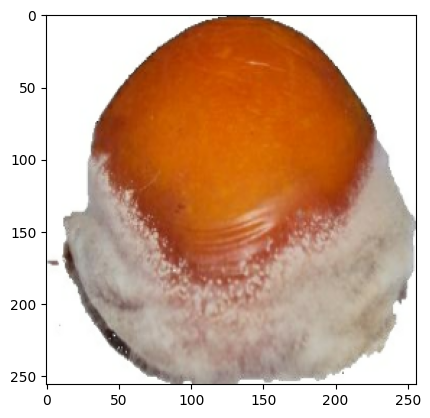

In [18]:
#running prediction on a sample image
for images_batch, labels_batch in test_data.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [23]:
# save the model as a h5 file

from tensorflow.keras.models import save_model
filepath = '../models/model1.h5'
model.save('my_model.keras')`
tf.keras.models.save_model(
    model, filepath, overwrite=True, include_optimizer=True, save_format='h5',
    signatures=None, options=None, save_traces=True
)